In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [4]:
%matplotlib inline

In [5]:
from IPython.display import clear_output

In [6]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score

In [7]:
from stable_baselines3 import PPO, A2C

In [8]:
import sys
sys.path.append(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code")
from RL_trading_envs import StockEnvTrainOnePerTime

In [9]:
from SL_evaluations import eval_model

In [10]:
def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.datadate >= start) & (df.datadate < end)]
    data=data.sort_values(['datadate','tic'])
    data.reset_index(inplace = True, drop = True)
    #data  = data[final_columns]
#     data.index = data.datadate.factorize()[0]
    return data

In [11]:
def get_actions(df, list_features, model):
    env = StockEnvTrainOnePerTime(df, list_features)
    episodes = 1
    list_actions = []
    for episode in range(episodes):
        done = False
        obs = env.reset()
        while not done:#not done:
            action, _ = model.predict(obs, deterministic = True)
            list_actions.append(action)
            obs, reward, done, info = env.step(action)
    return list_actions

In [23]:
def evaluate_subsample(df, n_sample_days, n_sample_assets, timesteps_by_eval, n_evals, list_features, agent_parameters = {}):
    #Sample assets and dates
    all_dates = df['datadate'].unique().tolist()
    all_assets = df['tic'].unique().tolist()
    if n_sample_days > 0:
        list_dates  = np.random.choice(all_dates, size = n_sample_days, replace = False)
    else:
        list_dates = all_dates
    if n_sample_assets > 0:
        list_tics   = np.random.choice(all_assets, size = n_sample_assets, replace = False)
    else:
        list_tics = all_assets
    df_sample   = df.query("datadate.isin(@list_dates) & tic.isin(@list_tics)")
    target      = df_sample['target_return'].reset_index(drop = True)
    #Loop to check moment of convergence
    env = StockEnvTrainOnePerTime(df_sample, list_features)
    # env = StockEnvTrainOnePerTime(df, list_features)
    model = PPO('MlpPolicy', env, verbose=0, **agent_parameters)
    list_acc = []
    list_std = []
    for _ in range(n_evals):
        clear_output(wait=True)
        model.learn(total_timesteps=timesteps_by_eval)
        list_actions = get_actions(df_sample, list_features, model)
        action = pd.Series(np.array(list_actions).reshape(-1))
#         list_acc.append(accuracy_score(target > 0, action > 0))
        list_acc.append((target * action).mean())
        list_std.append(action.std())
        plt.plot(list_acc, marker = '.')
        plt.show()
    return list_acc, list_std, action

In [13]:
df = pd.read_csv(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\done_data.csv")
df.loc[:, 'target_return'] = df.groupby('tic')['adjcp'].apply(lambda x: x.pct_change().shift(-1)).fillna(0)
df = data_split(df, df['datadate'].min(), df['datadate'].max())

In [14]:
list_features = ['macd', 'rsi', 'cci', 'adx']

In [15]:
qt = QuantileTransformer(output_distribution = 'normal')
df.loc[:, list_features] = qt.fit_transform(df[list_features])

In [16]:
df[list_features].quantile(0.99)

macd    2.326676
rsi     2.327062
cci     2.326885
adx     2.326880
Name: 0.99, dtype: float64

In [17]:
n_sample_assets   = 3
timesteps_by_eval = 1e4
n_evals           = 40

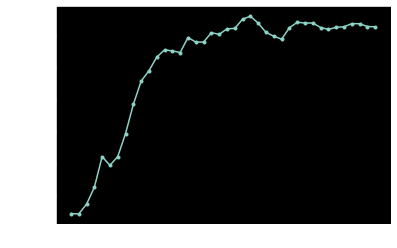

In [25]:
%matplotlib inline
list_acc     = []
list_std     = []
list_actions = []
list_n_days  = [10, 20, 40, 80, 160, 320, 640, 1280, 2925]
for n_sample_days in list_n_days:
    print("n_sample_days: " + str(n_sample_days))
    acc, std, action =evaluate_subsample(df = df,
                                         n_sample_days = n_sample_days,
                                         n_sample_assets = n_sample_assets,
                                         timesteps_by_eval = timesteps_by_eval,
                                         n_evals = n_evals,
                                         list_features = list_features)
    list_acc.append(acc[-1])
    list_std.append(std[-1])
    list_actions.append(action)
    

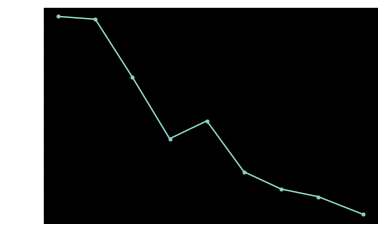

In [26]:
plt.plot(list_n_days, list_acc, marker = '.')
plt.xscale('log')

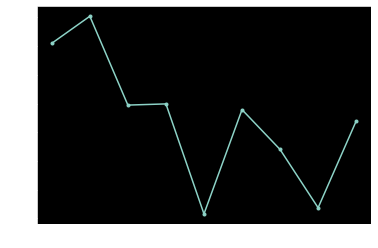

In [27]:
plt.plot(list_std, marker = '.')

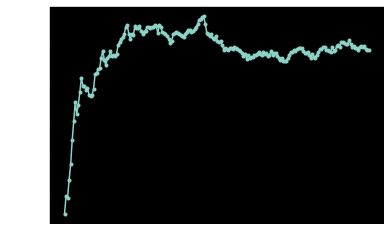

Wall time: 37min 45s


In [28]:
%%time
np.random.seed(0)
list_acc, list_std, action = evaluate_subsample(df = df,
                                                n_sample_days = -1,
                                                n_sample_assets = 3,
                                                timesteps_by_eval = 1e4,
                                                n_evals = 200,
                                                list_features = list_features)


<AxesSubplot:>

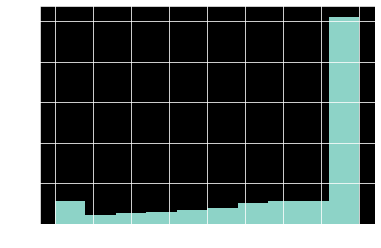

In [29]:
action.hist()

In [30]:
agent_parameters = dict(learning_rate=0.01,
                        n_steps=2048,
                        batch_size=2048,
                        n_epochs=1)

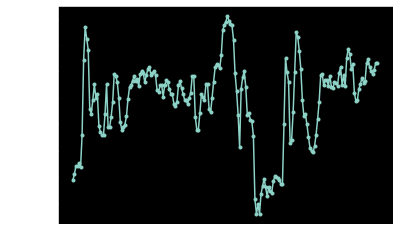

Wall time: 20min 34s


In [31]:
%%time
np.random.seed(0)
list_acc, list_std, action = evaluate_subsample(df = df,
                                                n_sample_days = -1,
                                                n_sample_assets = 3,
                                                timesteps_by_eval = 1e4,
                                                n_evals = 200,
                                                list_features = list_features,
                                               agent_parameters = agent_parameters)


<AxesSubplot:>

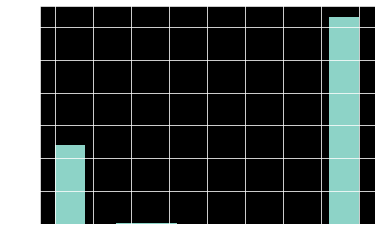

In [32]:
action.hist()

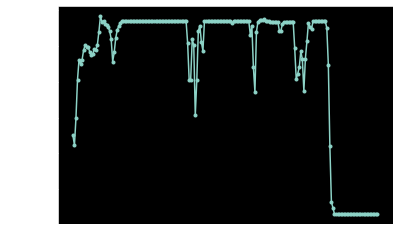

Wall time: 1h 16min 24s


In [36]:
%%time
np.random.seed(2)
list_acc, list_std, action = evaluate_subsample(df = df,
                                                n_sample_days = -1,
                                                n_sample_assets = -1,
                                                timesteps_by_eval = 1e4,
                                                n_evals = 200,
                                                list_features = list_features,
                                               agent_parameters = agent_parameters)


<AxesSubplot:>

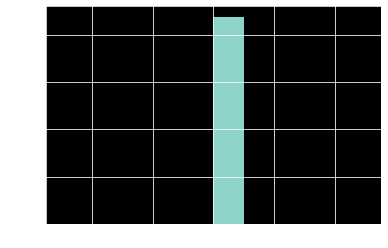

In [37]:
action.hist()

In [35]:
1

1

In [41]:
agent_parameters = dict(learning_rate=0.01,
                        n_steps=2048,
                        batch_size=2048,
                        n_epochs=1)

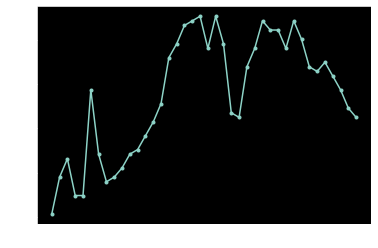

Wall time: 2min 54s


In [42]:
%%time
list_acc, list_std, action = evaluate_subsample(df = df,
                                                n_sample_days = 320,
                                                n_sample_assets = 3,
                                                timesteps_by_eval = 1e4,
                                                n_evals = 40,
                                                list_features = list_features,
                                               agent_parameters = agent_parameters)


<AxesSubplot:>

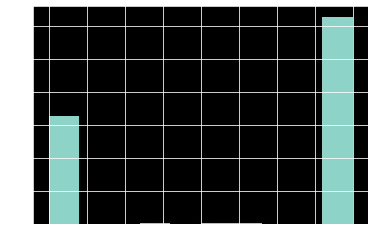

In [43]:
action.hist()